# Model 11: Cultural group selection

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model11.html

## Note
- The emergence and maintenance of cooperation requires explanation.
- The conflict between the individual and group level:
    - within groups, free-riding individuals do better than cooperating individuals,
    - yet groups of cooperators collectively do better than groups of free-riders.
- Solutions to the free-rider problem include kin selection and reciprocity.
- Yet each of these has limitations with respect to human cooperation:
    - kin selection cannot explain cooperation towards non-kin, which humans do frequently;
    - reciprocity cannot explain cooperation between strangers and breaks down in large groups, which are again common features of human societies;
    - and punishment is itself costly, leading to a second-order free-rider problem where non-punishing cooperators outcompete punishing cooperators.
- Consequently, some cultural evolution researchers have suggested that human cooperation can arise via __cultural group selection__ (Richerson et al. 2016).
    - This occurs when more-cooperative groups outcompete less-cooperative groups in between-group competition.
    - Genetic group selection does not seem to work:
        - between-group genetic variation is easily broken down by migration,
        - and individual-level natural selection is too strong.
    - Cultural evolution, however, provides better conditions:
        - rapid cultural selection (Model 3) can generate differences between groups,
        - and processes such as conformity (Model 5) or polarisation (Model 10) can maintain between-group cultural variation despite frequent migration (see Model 7).
    - Between-group competition can occur via direct conquest, e.g. warfare, where more-cooperative societies full of self-sacrificial fighters out-compete less-cooperative societies full of deserting back-stabbers.
    - Or it can occur indirectly, such as where more-cooperative societies, e.g. ones with better social welfare systems, attract more migrants than less-cooperative societies.
    - Success in between-group competition does not necessarily require the death of the defeated group’s members.
    - Instead, defeated group members can disband and join the winning group.
- This model ([Boyd, Gintis, Bowles & Richerson (2003)](https://doi.org/10.1073/pnas.0630443100)) features
    - costly (i.e. altruistic) punishment within groups,
    - mixing / migration between groups,
    - payoff-biased social learning and
    - between-group selection.

In [1]:
using JupyterFormatter
enable_autoformat()

using Statistics
using StatsBase
using LinearAlgebra
using Plots
using Plots.PlotMeasures

using Test: @testset, @test

println("Julia version: ", VERSION)

Julia version: 1.9.2


## Stage 0: Setup agents

- Make traits and payoff table.
- Each agent can be C (cooperator), D (defector) or P (punisher). C cooperates, D defects, and P cooperates and punishes.
- `n_group`: Group count. Each column is a group.
- `n_agent`: Agent count per group
- Starting conditions
    - (a) one group of all Cs and the rest all Ds
    - (b) all Ds (with Ps and Cs only appearing via mutation)
    - (c) random behaviours
    - (d) one group of all Ps and the rest all Ds

In [2]:
function make_traits(
    n_agent::Int,
    n_group::Int,
    starting_condition::String = "d",
)::Matrix{String}
    traits = fill("D", (n_agent, n_group))

    if starting_condition == "a"
        traits[:, 1] = fill("C", n_agent)
    elseif starting_condition == "c"
        traits = rand(["C", "P", "D"], (n_agent, n_group))
    elseif starting_condition == "d"
        traits[:, 1] = fill("P", n_agent)
    end

    traits
end

function make_payoffs(n_agent::Int, n_group::Int)::Matrix{Float64}
    fill(1.0, (n_agent, n_group))
end;

In [3]:
@testset "make_traits" begin
    traits = make_traits(4, 3)
    @test traits[:, 1] == ["P", "P", "P", "P"]
    @test traits[:, 2] == ["D", "D", "D", "D"]
    @test traits[:, 3] == ["D", "D", "D", "D"]
    @test traits == [
        "P" "D" "D"
        "P" "D" "D"
        "P" "D" "D"
        "P" "D" "D"
    ]
end

@testset "make_payoffs" begin
    payoffs = make_payoffs(4, 3)
    @test size(payoffs) == (4, 3)
    @test payoffs == fill(1.0, (4, 3))
end;

Test Summary: | Pass  Total  Time
make_traits   |    4      4  0.3s
Test Summary: | Pass  Total  Time
make_payoffs  |    2      2  0.0s


## Stage 1: Cooperation

- Update payoffs of C and P.
- Cooperators and punishers cooperate with probability $1 − e$ and defect with probability $e$. The parameter $e$ represents errors.
- Cooperation reduces the cooperating agent’s payoff by $c$. This makes cooperation costly.
- Defectors always defect and pay no cost.

In [70]:
function cooperation!(
    payoffs::Matrix{Float64},
    traits::Matrix{String},
    b::Float64, # benefit
    c::Float64, # cost of cooperation
    e::Float64, # error rate of cooperation
)::Matrix{Float64}
    n_agent, n_group = size(payoffs)
    contributors = (rand(n_agent, n_group) .> e) .&& (traits .== "C" .|| traits .== "P")
    payoffs .-= contributors .* c

    # Each contributor generates a payoff benefit b which is shared equally amongst all group members (including defectors).
    payoffs .+= sum(contributors, dims = 1) .* b ./ n_agent
end;

In [87]:
@testset "cooperation!" begin
    @testset "b = 0.0" begin
        traits = [
            "C" "P" "D"
            "C" "P" "D"
            "C" "P" "D"
            "C" "P" "D"
        ]
        payoffs = make_payoffs(4, 3)
        cooperation!(payoffs, traits, 0.0, 0.2, 0.0)
        @test payoffs == [
            0.8 0.8 1.0
            0.8 0.8 1.0
            0.8 0.8 1.0
            0.8 0.8 1.0
        ]
        payoffs = make_payoffs(4, 3)
        cooperation!(payoffs, traits, 0.0, 0.2, 1.0)
        @test payoffs == [
            1.0 1.0 1.0
            1.0 1.0 1.0
            1.0 1.0 1.0
            1.0 1.0 1.0
        ]

        traits = fill("C", (50, 20))
        @test mean(cooperation!(make_payoffs(50, 20), traits, 0.0, 0.2, 0.5)) ≈ 0.9 atol =
            10^-2
    end

    @testset "b != 0.0" begin
        traits = [
            "C" "P" "C" "P" "D"
            "P" "C" "P" "D" "D"
            "C" "P" "D" "D" "D"
            "P" "D" "D" "D" "D"
        ]
        payoffs = make_payoffs(4, 5)
        cooperation!(payoffs, traits, 0.5, 0.2, 0.0)
        @test payoffs == [
            1.3 1.175 1.05 0.925 1.0
            1.3 1.175 1.05 1.125 1.0
            1.3 1.175 1.25 1.125 1.0
            1.3 1.375 1.25 1.125 1.0
        ]

        payoffs = make_payoffs(4, 5)
        cooperation!(payoffs, traits, 0.0, 0.2, 0.0)
        @test payoffs == [
            0.8 0.8 0.8 0.8 1.0
            0.8 0.8 0.8 1.0 1.0
            0.8 0.8 1.0 1.0 1.0
            0.8 1.0 1.0 1.0 1.0
        ]
    end
end;

Test Summary: | Pass  Total  Time
cooperation!  |    5      5  0.0s


## Stage 2: Punishment

- Update payoffs of D and P.
- Punishers (Ps) punish every agent in their group who defected in the first stage.
- Punishment reduces each defector’s payoff by $p/n$ at a cost of $k/n$ to the punisher.
- The parameter $k$ makes punishment costly.
- The more punishers there are in a group, the more punishment defectors receive.
- The more defectors there are, the more costly punishment is to the punisher.

In [6]:
function punishment!(
    payoffs::Matrix{Float64},
    traits::Matrix{String},
    p::Float64, # punishment (cost to defector)
    k::Float64, # cost to punisher
    fixed_k::Bool = false, # flag of fixed k
)::Matrix{Float64}
    n_agent, n_group = size(payoffs)
    _k = k / n_agent
    _p = p / n_agent

    for group = 1:n_group
        _traits = traits[:, group]
        p_count = count(t -> t == "P", _traits)
        d_count = fixed_k ? n_agent : count(t -> t == "D", _traits)

        payoffs[:, group] .-= (_traits .== "P") .* (d_count * _k)
        payoffs[:, group] .-= (_traits .== "D") .* (p_count * _p)
    end

    payoffs
end;

In [7]:
@testset "punishment!" begin
    # Test condition
    n_group = 7
    n_agent = 5
    p = 0.7  # cost to defector
    k = 0.2  # cost to punisher
    traits = make_traits(n_agent, n_group)
    traits[:, 1] = ["C", "D", "D", "D", "D"]
    traits[:, 2] = ["P", "D", "D", "D", "D"]
    traits[:, 3] = ["C", "P", "D", "D", "D"]
    traits[:, 4] = ["C", "C", "D", "D", "D"]
    traits[:, 5] = ["P", "P", "D", "D", "D"]
    traits[:, 6] = ["C", "C", "P", "P", "D"]

    @test traits == [
        "C" "P" "C" "C" "P" "C" "D"
        "D" "D" "P" "C" "P" "C" "D"
        "D" "D" "D" "D" "D" "P" "D"
        "D" "D" "D" "D" "D" "P" "D"
        "D" "D" "D" "D" "D" "D" "D"
    ]

    payoffs = make_payoffs(n_agent, n_group)

    # Target
    punishment!(payoffs, traits, p, k)

    # Expected results
    @test payoffs[:, 1] == [1.0, 1.0, 1.0, 1.0, 1.0]

    @test 1.0 - 4k / 5 == 0.84
    @test 1.0 - 1p / 5 == 0.86
    @test payoffs[:, 2] == [0.84, 0.86, 0.86, 0.86, 0.86]

    @test 1.0 - 3k / 5 == 0.88
    @test 1.0 - 1p / 5 == 0.86
    @test payoffs[:, 3] == [1.0, 0.88, 0.86, 0.86, 0.86]

    @test payoffs[:, 4] == [1.0, 1.0, 1.0, 1.0, 1.0]

    @test 1.0 - 3k / 5 == 0.88
    @test 1.0 - 2p / 5 == 0.72
    @test payoffs[:, 5] == [0.88, 0.88, 0.72, 0.72, 0.72]

    @test 1.0 - 1k / 5 == 0.96
    @test 1.0 - 2p / 5 == 0.72
    @test payoffs[:, 6] == [1.0, 1.0, 0.96, 0.96, 0.72]

    @test payoffs[:, 7] == [1.0, 1.0, 1.0, 1.0, 1.0]
end;

Test Summary: | Pass  Total  Time
punishment!   |   16     16  0.2s


## Stage 3: Payoff-biased social learning with inter-group mixing

- Update traits.
- $m$ controls the rate of between-group mixing.
    - With probability $1 − m$, agents interact with a random member of their own group.
    - With probability  $m$, agents interact with a random member of another group.
- Once a demonstrator is chosen, the focal individual then copies the behaviour (C, D or P) of the demonstrator with probability $\frac{\pi_{dem}}{\pi_{dem} + \pi_{focal}}$ where $\pi$ means payoff.
    - High-payoff behaviours are therefore more likely to be copied.

In [8]:
function get_demonstrator(
    focal_group::Int,
    focal_agent::Int,
    n_group::Int,
    n_agent::Int,
    m::Float64,
)::Tuple{Int,Int}
    if rand() > m
        # With probability 1 − m, agents interact with a random member of their own group.
        demonstrator_group = focal_group
        demonstrator_agent = rand([i for i in 1:n_agent if i != focal_agent])
    else
        # With probability m, agents interact with a random member of another group.
        demonstrator_group = rand([i for i in 1:n_group if i != focal_group])
        demonstrator_agent = rand(1:n_agent)
    end

    (demonstrator_group, demonstrator_agent)
end

function payoff_biased_social_learning!(
    traits::Matrix{String},
    payoffs::Matrix{Float64},
    m::Float64,
)::Matrix{String}
    n_agent, n_group = size(payoffs)
    previous_traits = copy(traits)

    for focal_group = 1:n_group
        for focal_agent = 1:n_agent
            demonstrator_group, demonstrator_agent =
                get_demonstrator(focal_group, focal_agent, n_group, n_agent, m)
            focal_payoff = payoffs[focal_agent, focal_group]
            demonstrator_payoff = payoffs[demonstrator_agent, demonstrator_group]
            prob_to_copy = demonstrator_payoff / (focal_payoff + demonstrator_payoff)

            if prob_to_copy > rand()
                traits[focal_agent, focal_group] =
                    previous_traits[demonstrator_agent, demonstrator_group]
            end
        end
    end

    traits
end;

In [9]:
@testset "get_demonstrator" begin
    # Test condition:
    focal_group = 1
    focal_agent = 1
    n_group = 5
    n_agent = 10
    m = 0.2  # With probability m, agents interact with a random member of another group.
    trial = 10^7

    # Target:
    demonstrators =
        [get_demonstrator(focal_group, focal_agent, n_group, n_agent, m) for _ = 1:trial]

    # Expected results:
    # 1 - m の確率で同じグループが選ばれる
    @test count(d -> d[1] == 1, demonstrators) / trial ≈ (1 - m) atol = 10^-2
    # m の確率で別のグループが選ばれる
    @test count(d -> d[1] != 1, demonstrators) / trial ≈ m atol = 10^-2
    @test count(d -> d[1] == 5, demonstrators) / trial ≈ m / (n_group - 1) atol = 10^-2

    # 同じグループのエージェントがdemonstratorになった場合は、2〜10のエージェントがランダムに選ばれる
    @test mean([a for (g, a) in demonstrators if g == focal_group]) ≈ mean([2, 3, 4, 5, 6, 7, 8, 9, 10]) atol =
        10^-2
    # 別のグループのエージェントがdemonstratorになった場合は、1〜10のエージェントがランダムに選ばれる
    @test mean([a for (g, a) in demonstrators if g != focal_group]) ≈ mean([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) atol =
        10^-2
end;

Test Summary:    | Pass  Total  Time
get_demonstrator |    5      5  2.1s


## Stage 4: Group selection

- Groups are paired at random and with probability $\epsilon$ enter into a contest.
- the probability that group 1 defeats group 2 in a pair is $\frac{1}{2} + \frac{d_2 - d_1}{2}$,
    - where $d_1$ is the proportion of defectors in group 1 of a pair and
    - $d_2$ is the proportion of defectors in group 2 of the pair.

In [10]:
function group_selection!(traits::Matrix{String}, e::Float64, ϵ::Float64)::Matrix{String}
    n_agent, n_group = size(traits)

    # Matrix of randomly selected pairs of groups
    contests = sample(1:n_group, (n_group ÷ 2, 2), replace = false)
    # Keep contests with prob ϵ
    contests = contests[rand(n_group ÷ 2).<ϵ, :]

    # Defectors (Ds and Ps/Cs with probability e)
    defectors =
        (traits .== "D") .||
        ((rand(n_agent, n_group) .< e) .&& (traits .== "C" .|| traits .== "P"))

    for group in eachrow(contests)
        # probability that group 1 defeats group 2
        d1 = sum(defectors[:, group[1]]) / n_agent
        d2 = sum(defectors[:, group[2]]) / n_agent
        d = 0.5 + (d2 - d1) / 2

        if rand() < d
            # group 1 wins
            traits[:, group[2]] .= traits[:, group[1]]
        else
            # group 2 wins
            traits[:, group[1]] .= traits[:, group[2]]
        end
    end

    traits
end;

In [11]:
n_group = 10
ϵ = 0.0
contests = sample(1:n_group, (n_group ÷ 2, 2), replace = false)
contests = contests[rand(n_group ÷ 2).<ϵ, :]

0×2 Matrix{Int64}

## Stage 5: Mutation

In [12]:
function mutate(trait::String)::String
    trait == "C" && return rand(["P", "D"])
    trait == "P" && return rand(["C", "D"])
    trait == "D" && return rand(["C", "P"])
end

function mutation!(traits::Matrix{String}, μ::Float64)::Matrix{String}
    traits .= [μ > rand() ? mutate(t) : t for t in traits]
end;

In [13]:
@testset "mutation!" begin
    prev_traits = rand(["C", "P", "D"], 7, 11)
    post_traits = mutation!(copy(prev_traits), 1.0)
    @test [prev != post for (prev, post) in zip(prev_traits, post_traits)] == fill(true, (7, 11))

    prev_traits = rand(["C", "P", "D"], 7, 11)
    post_traits = mutation!(copy(prev_traits), 0.0)
    @test [prev == post for (prev, post) in zip(prev_traits, post_traits)] == fill(true, (7, 11))
end;

Test Summary: | Pass  Total  Time
mutation!     |    2      2  0.1s


## Run all

In [78]:
function run_all(;
    n_group::Int = 128,  # group count
    n_agent::Int = 4,    # agent count in a group
    t_max::Int = 4000,   # time steps
    starting_condition::String = "d",
    e::Float64 = 0.02,   # error rate of cooperation
    b::Float64 = 0.0,    # benefit of within-group interaction
    c::Float64 = 0.2,    # cost of cooperation
    m::Float64 = 0.01,   # rate of between-group mixing
    p::Float64 = 0.8,    # punishment (cost to defector)
    k::Float64 = 0.2,    # cost to punisher
    fixed_k::Bool = false, # flag of fixed k
    μ::Float64 = 0.01,   # mutation rate
    ϵ::Float64 = 0.015,   # frequency of conflict
    title::String = "",
)::Matrix{Float64}

    traits = make_traits(n_agent, n_group, starting_condition)
    outputs = fill(0.0, (t_max, 2))

    for t = 1:t_max
        payoffs = make_payoffs(n_agent, n_group)
        cooperation!(payoffs, traits, b, c, e)
        punishment!(payoffs, traits, p, k, fixed_k)
        payoff_biased_social_learning!(traits, payoffs, m)
        group_selection!(traits, e, ϵ)
        mutation!(traits, μ)

        # save cooperator rate
        outputs[t, 1] = count(t -> t == "C", traits) / (n_group * n_agent)
        outputs[t, 2] = count(t -> t in ["C", "P"], traits) / (n_group * n_agent)
    end

    # Plot
    if title != ""
        p = plot(
            ylims = (-0.01, 1.01),
            title = title,
            xlabel = "generation",
            ylabel = "frequency of cooperators",
        )
        plot!(outputs[:, 2], lc = :blue, label = "Cooperator and Punisher")
        plot!(outputs[:, 1], lc = :skyblue, label = "Cooperator")

        cooperator_rate1 = mean(outputs[Int(round(t_max * 0.8)):t_max, 1])
        cooperator_rate2 = mean(outputs[Int(round(t_max * 0.8)):t_max, 2])
        println("Cooperator and Punisher: $cooperator_rate2")
        println("Cooperator:\t\t $cooperator_rate1")

        display(p)
    end

    return outputs
end;

# Results

Cooperator and Punisher: 0.821129350031211
Cooperator:		 0.2962410268414482


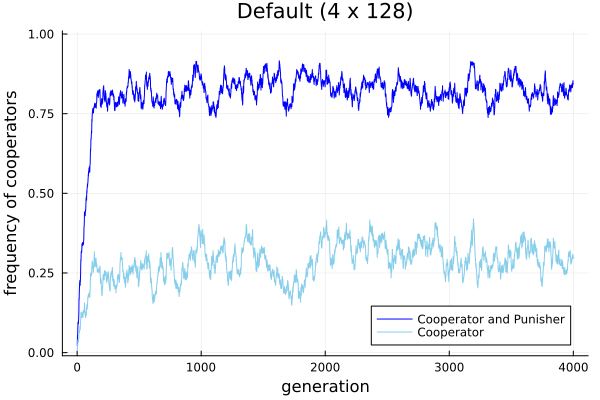

Cooperator and Punisher: 0.6899746288818664
Cooperator:		 0.24527049927824593


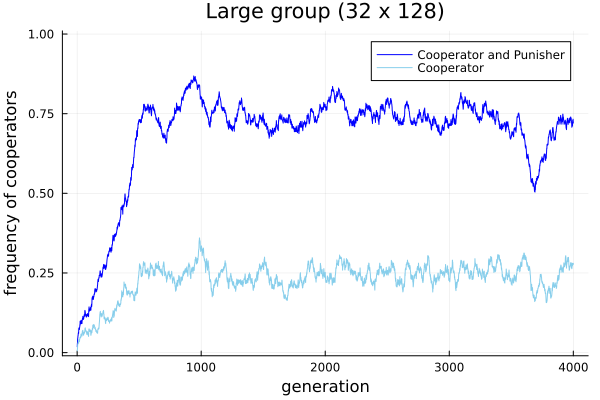

In [79]:
run_all(title = "Default (4 x 128)");
run_all(n_agent = 32, title = "Large group (32 x 128)");

1グループ当たりのエージェント数を増やすと協力率はやや下がる。

グループが大きくなると協力が難しくなるのは、よく知られた結論である。

`p` (cost to defector) と `k` (cost to punisher) を`0`にすることで、モデルから罰の要素を取り除くと、協力は成立しなくなる。

Cooperator and Punisher: 0.10305904240792758
Cooperator:		 0.05244664872034956


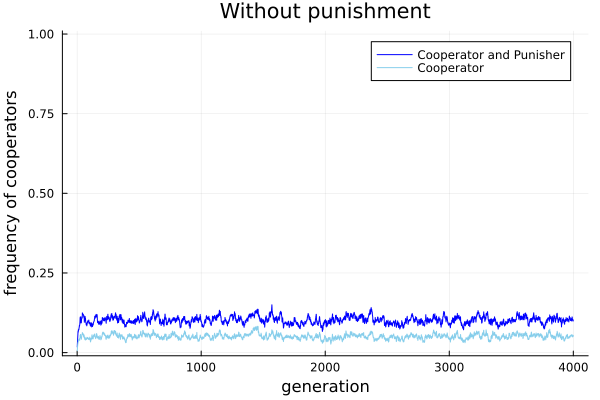

In [73]:
run_all(n_agent = 32, p = 0.0, k = 0.0, title = "Without punishment");

Cooperator and Punisher: 0.16794802395443195
Cooperator:		 0.07880743552980649


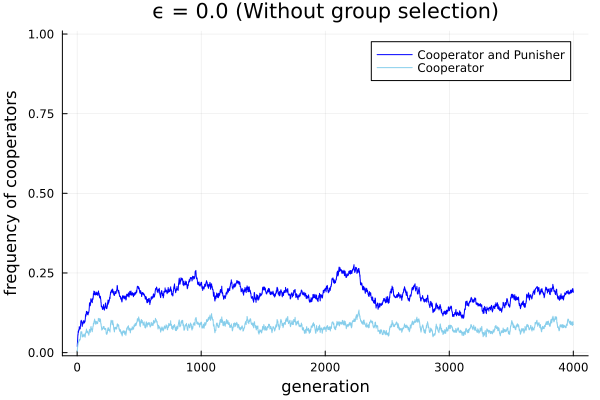

Cooperator and Punisher: 0.5665046987164482
Cooperator:		 0.1920051717579588


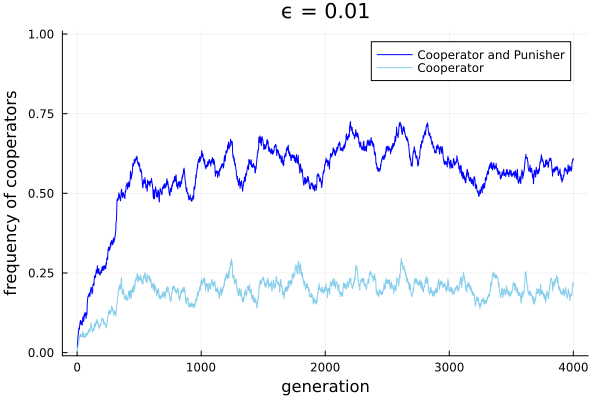

Cooperator and Punisher: 0.7834667724914169
Cooperator:		 0.2730827188670412


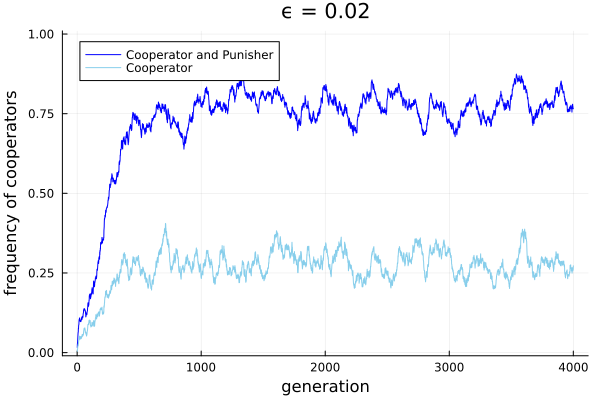

In [17]:
run_all(n_agent = 32, ϵ = 0.0, title = "ϵ = 0.0 (Without group selection)");
run_all(n_agent = 32, ϵ = 0.01, title = "ϵ = 0.01");
run_all(n_agent = 32, ϵ = 0.02, title = "ϵ = 0.02");

Cooperator and Punisher: 0.4348723641346754
Cooperator:		 0.18114045675327714


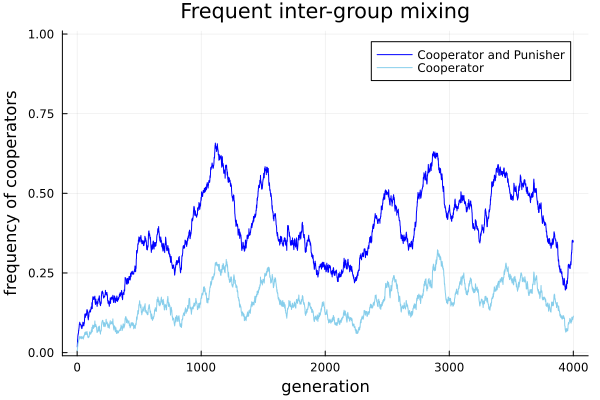

In [18]:
run_all(n_agent = 32, m = 0.05, title = "Frequent inter-group mixing");

## Fig 1. Frequency of cooperation across a range of group sizes

In [19]:
function plot_summary(
    output::Matrix,
    xticks::Tuple,
    legendtitle::String,
    param_name::String,
    param_vec::Vector,
)::Plots.Plot
    p = plot(
        legendtitle = legendtitle,
        xlabel = "group size",
        ylabel = "frequency of cooperation",
        xticks = (1:length(n_agent_vec), n_agent_vec),
        ylims = (-0.01, 1.01),
        margin = 3mm,
    )
    for (i, col) in enumerate([:darkblue, :red, :plum])
        plot!(
            1:length(n_agent_vec),
            output[:, i],
            markershape = [:square, :utriangle, :circle][i],
            markercolor = col,
            linecolor = col,
            label = "$param_name = $(param_vec[i])",
        )
    end
    p
end;

In [20]:
t_max = 5000
n_agent_vec = [4, 8, 16, 32, 64]
_xticks = (1:length(n_agent_vec), n_agent_vec);

### Fig 1 (a)

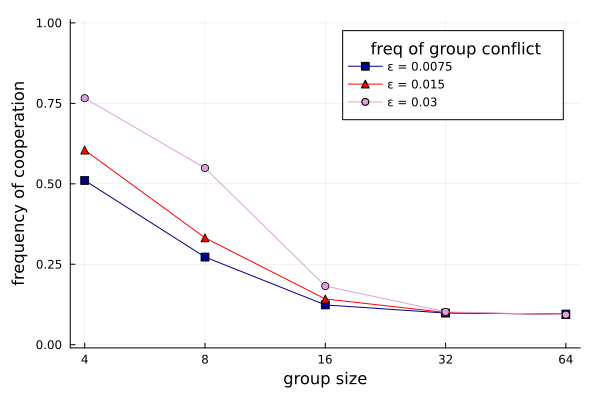

In [21]:
ϵ_vec = [0.0075, 0.015, 0.03]
output = fill(0.0, length(n_agent_vec), length(ϵ_vec))

for i = 1:length(ϵ_vec)
    for j = 1:length(n_agent_vec)
        # without punishment
        _output =
            run_all(t_max = t_max, n_agent = n_agent_vec[j], ϵ = ϵ_vec[i], p = 0.0, k = 0.0)
        _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
        output[j, i] = _output
    end
end

plot_summary(output, _xticks, "freq of group conflict", "ε", ϵ_vec)

### Fig 1 (b)

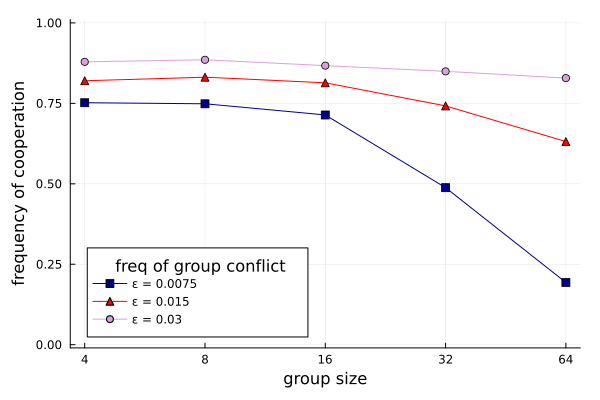

In [22]:
for i = 1:length(ϵ_vec)
    for j = 1:length(n_agent_vec)
        # with punishment
        _output = run_all(t_max = t_max, n_agent = n_agent_vec[j], ϵ = ϵ_vec[i])
        _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
        output[j, i] = _output
    end
end

plot_summary(output, _xticks, "freq of group conflict", "ε", ϵ_vec)

# Exercize 1

## (a) Error rate $e$ across a range of group sizes

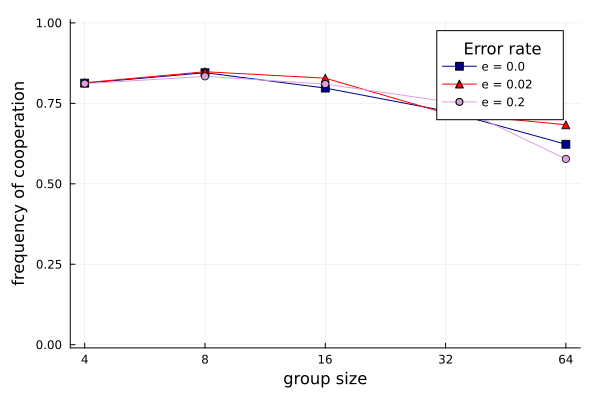

In [23]:
e_vec = [0.00, 0.02, 0.2]
output = fill(0.0, length(n_agent_vec), length(e_vec))

for i = 1:length(e_vec)
    for j = 1:length(n_agent_vec)
        _output = run_all(t_max = t_max, n_agent = n_agent_vec[j], e = e_vec[i])
        _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
        output[j, i] = _output
    end
end

plot_summary(output, _xticks, "Error rate", "e", e_vec)

## (b) Cost of cooperation $c$ across a range of group sizes

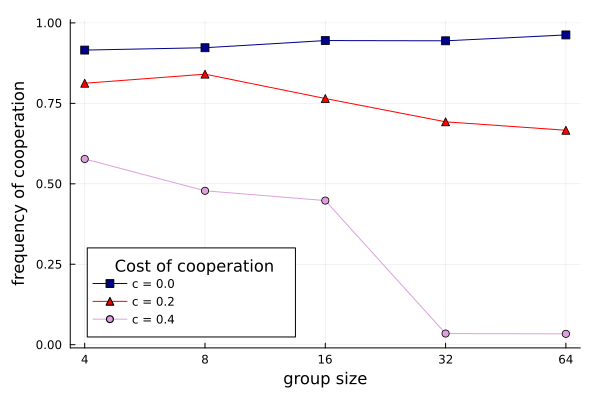

In [24]:
c_vec = [0.0, 0.2, 0.4]
output = fill(0.0, length(n_agent_vec), length(c_vec))

for i = 1:length(c_vec)
    for j = 1:length(n_agent_vec)
        _output = run_all(t_max = t_max, n_agent = n_agent_vec[j], c = c_vec[i])
        _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
        output[j, i] = _output
    end
end

plot_summary(output, _xticks, "Cost of cooperation", "c", c_vec)

## (c) Mutation rate $\mu$ across a range of group sizes

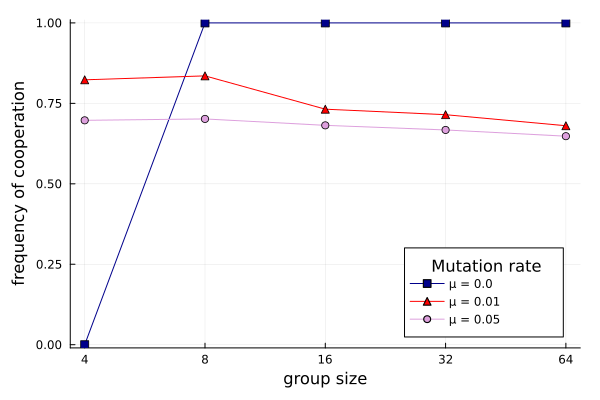

In [25]:
μ_vec = [0.0, 0.01, 0.05]
output = fill(0.0, length(n_agent_vec), length(μ_vec))

for i = 1:length(μ_vec)
    for j = 1:length(n_agent_vec)
        _output = run_all(t_max = t_max, n_agent = n_agent_vec[j], μ = μ_vec[i])
        _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
        output[j, i] = _output
    end
end

plot_summary(output, _xticks, "Mutation rate", "μ", μ_vec)

## (d) Number of groups $n_{group}$ across a range of group sizes

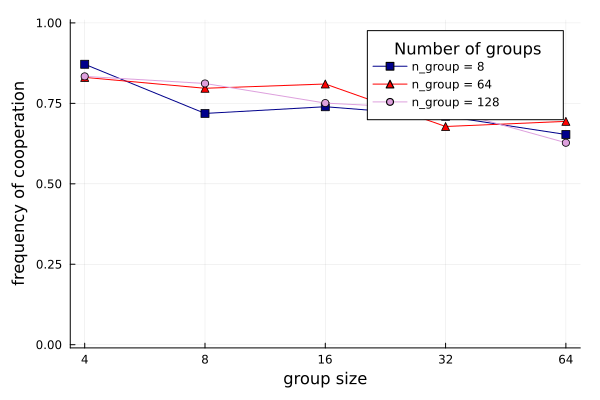

In [26]:
n_group_vec = [8, 64, 128]
output = fill(0.0, length(n_agent_vec), length(n_group_vec))

for i = 1:length(n_group_vec)
    for j = 1:length(n_agent_vec)
        _output = run_all(t_max = t_max, n_agent = n_agent_vec[j], n_group = n_group_vec[i])
        _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
        output[j, i] = _output
    end
end

plot_summary(output, _xticks, "Number of groups", "n_group", n_group_vec)

# Exercize 2

Recreate Boyd et al.’s (2003) other figures, adapting the code above used to recreate their Figure 1b. Do you get the same results?

## Fig 2 Rate of between-group mixing ($m$) across a range of group sizes

The evolution of cooperation is strongly affected by rate of mixing between groups. (a) The long run average frequency of cooperation (i.e., the sum of the frequencies of contributors and punishers) as a function of group size when there is no punishment (p = k = 0) for three mixing rates, 0.002, 0.01, and 0.05. Group selection is ineffective unless groups are quite small. (b) When there is punishment (p = 0.8, k = 0.2), group selection can maintain cooperation in larger groups for all rates of mixing. However, at higher rates of mixing, cooperation does not persist in the largest groups.

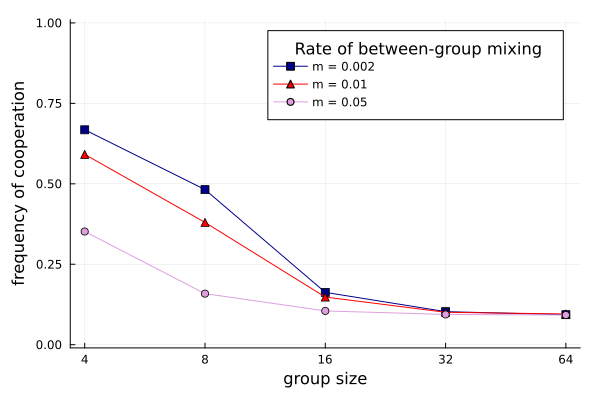

In [27]:
m_vec = [0.002, 0.01, 0.05]
output = fill(0.0, length(n_agent_vec), length(m_vec))

for i = 1:length(m_vec)
    for j = 1:length(n_agent_vec)
        _output =
            run_all(t_max = t_max, n_agent = n_agent_vec[j], p = 0.0, k = 0.0, m = m_vec[i])
        _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
        output[j, i] = _output
    end
end

plot_summary(output, _xticks, "Rate of between-group mixing", "m", m_vec)

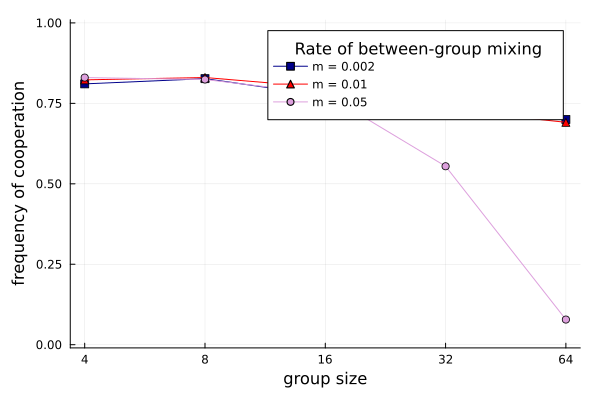

In [28]:
for i = 1:length(m_vec)
    for j = 1:length(n_agent_vec)
        _output = run_all(t_max = t_max, n_agent = n_agent_vec[j], m = m_vec[i])
        _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
        output[j, i] = _output
    end
end

plot_summary(output, _xticks, "Rate of between-group mixing", "m", m_vec)

## Fig 3. Punishment $p$ across a range of group sizes

The evolution of cooperation is sensitive to the cost of being punished (p). Here we plot the long run average frequency of cooperation with the base case cost of being punished (p = 0.8) and with a lower value of p. Lower values of p result in much lower levels of cooperation.

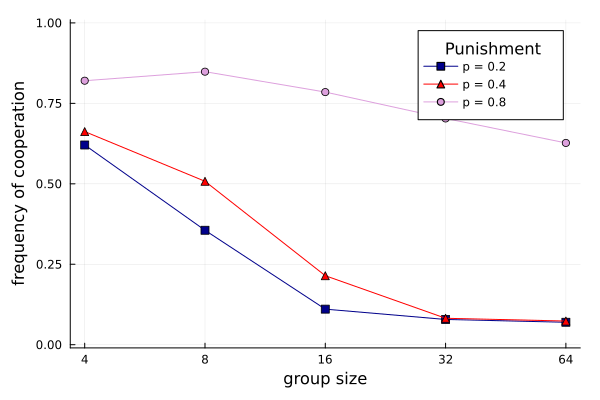

In [29]:
p_vec = [0.2, 0.4, 0.8]
output = fill(0.0, length(n_agent_vec), length(p_vec))

for i = 1:length(p_vec)
    for j = 1:length(n_agent_vec)
        _output = run_all(t_max = t_max, n_agent = n_agent_vec[j], p = p_vec[i])
        _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
        output[j, i] = _output
    end
end

plot_summary(output, _xticks, "Punishment", "p", p_vec)

## Fig 4. Fixed v.s. Variable punishment costs

Punishment does not aid in the evolution of cooperation when the costs born by punishers ($k$) are fixed, independent of the number of defectors in the group. Here we plot the long run average frequency of cooperation when the costs of punishing ($k$) are proportional to the frequency of defectors (variable cost), fixed at a constant cost equal to the cost of cooperating ($c$), and when there is no punishment.

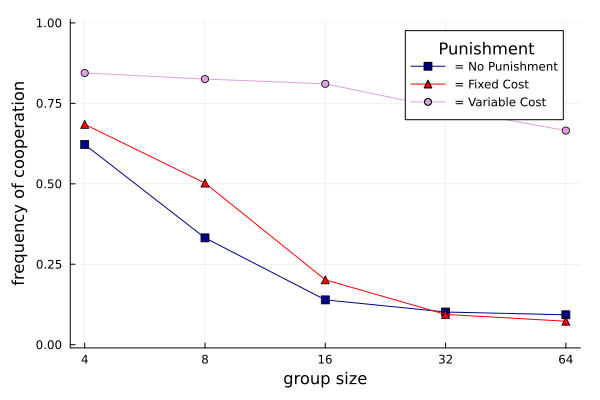

In [30]:
output = fill(0.0, length(n_agent_vec), length(p_vec))

# No Punishment
for j = 1:length(n_agent_vec)
    _output = run_all(t_max = t_max, n_agent = n_agent_vec[j], p = 0.0, k = 0.0)
    _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
    output[j, 1] = _output
end

# Fixed Cost
for j = 1:length(n_agent_vec)
    _output = run_all(t_max = t_max, n_agent = n_agent_vec[j], fixed_k = true)
    _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
    output[j, 2] = _output
end

# Variable Cost
for j = 1:length(n_agent_vec)
    _output = run_all(t_max = t_max, n_agent = n_agent_vec[j])
    _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
    output[j, 3] = _output
end

plot_summary(
    output,
    _xticks,
    "Punishment",
    "",
    ["No Punishment", "Fixed Cost", "Variable Cost"],
)

# Exercize 3

Change the starting conditions, to

- (a) one group of all Cs and the rest all Ds;
- (b) all Ds (with Ps and Cs only appearing via mutation); and
- (c) random behaviours.

Does cooperation still emerge with these different starting conditions?

__→ It is confirmed that the results does not depend on the starting condition.__

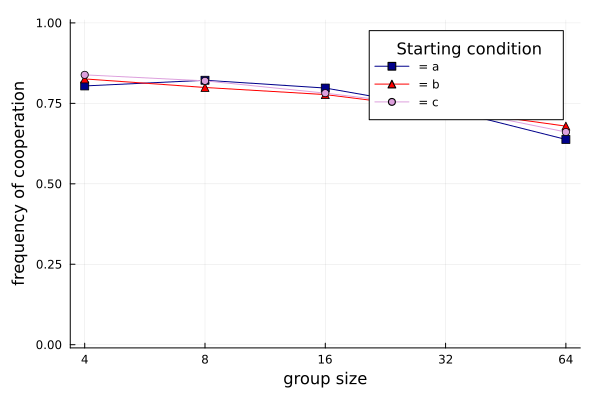

In [31]:
starting_condition_vec = ["a", "b", "c"]
output = fill(0.0, length(n_agent_vec), length(ϵ_vec))

for i = 1:length(starting_condition_vec)
    for j = 1:length(n_agent_vec)
        _output = run_all(
            t_max = t_max,
            n_agent = n_agent_vec[j],
            starting_condition = starting_condition_vec[i],
        )
        _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
        output[j, i] = _output
    end
end

plot_summary(output, _xticks, "Starting condition", "", starting_condition_vec)

# Exercize 4

Add a new parameter $b$ to the Cooperation function. Each cooperator (Cs and Ps with probability $1 − e$ ) generates a payoff benefit $b$ which is shared equally amongst all group members (including defectors). This simulates the standard 'Public Goods Game' from economics. Now cooperation generates within-group benefits, as well as between-group benefits via group selection. Explore the effect of different values of $b$ on overall cooperation levels.

__→ The value of $b$ does not affect the results because cooperators (Cs and Ps) lose more than defectors (Ds) regardless of $b$.__

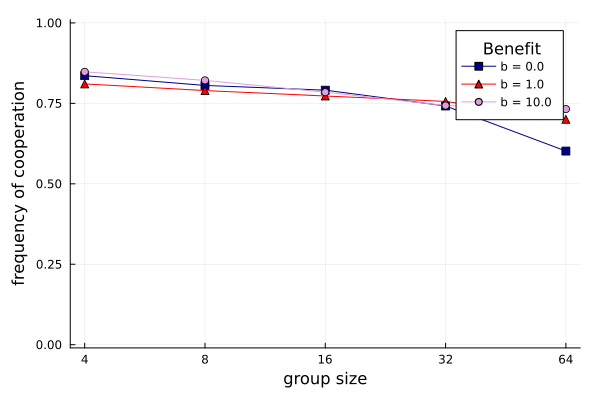

In [89]:
b_vec = [0.0, 1.0, 10.0]
output = fill(0.0, length(n_agent_vec), length(b_vec))

for i = 1:length(b_vec)
    for j = 1:length(n_agent_vec)
        _output = run_all(t_max = t_max, n_agent = n_agent_vec[j], b = b_vec[i])
        _output = mean(_output[Int(round(t_max * 0.8)):t_max, 2])
        output[j, i] = _output
    end
end

plot_summary(output, _xticks, "Benefit", "b", b_vec)